In [1]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
from tqdm import tqdm
matplotlib.rcParams.update({'font.size': 18})

Reference: "Asymptotic formulae for likelihood-based tests of new physics" https://arxiv.org/abs/1007.1727


### Test statistics $q_0$ for discovery of a positive signal



To discover new signal, we need to reject $\mu$ = 0 hypothesis. The test statistics becomes

$q_0 = 
-2\ln \lambda(0)$ for $\hat{\mu} \geq 0$ and zero for $\hat{\mu} < 0$, 

where $\lambda(0)$ is the profile likelihood ratio for $\mu$ = 0: 

$\lambda(\mu) = \frac{L(\mu,\hat{\hat{\theta}})}{L(\hat{\mu}, \hat{\theta})}$

In this case the $p$-value is computed as

$p_0 = \int_{q_{0,\textrm{obs}}}^{\infty} f(q_0 | 0) dq_0$

In a counting experiment, where one observes a number of events $n$, assumed to follow a Poisson distribution with an expectation value $E[n] = \mu s + b$, where $b$ is a nuissance parameter constrained by a control measurement, with expectation value $E[m] = \tau b$. 

$b$ is the expected MC in the signal region and $\tau$ is the transfer factor from the control to the signal region. Thus the data consist of two measured values: $n$ from signal region and $m$ from control region. The parameter of interest is $\mu$ and one nuissance parameter is $b$. The likelihood function for $\mu$ and $b$ is the product of two Poisson terms:

$ L(\mu, b) = \frac{(\mu s + b)^n}{n!}e^{-(\mu s + b)} \frac{(\tau b)^m}{m!} e^{-\tau b}
$

In our case, since we measure $b$ from 10% of the signal region, we take $\tau$ = 0.1 (or 1/9... depending on how observed data is obtained)

Maximum likelihood estimator returns:

$\hat{\mu} = \frac{n - m/\tau}{s} $

$\hat{b} = \frac{m}{\tau} $

$\hat{\hat{b}} = \frac{n+m-(1+\tau)\mu s}{2(1+\tau)} + \left[ \frac{(n+m - (1+\tau) \mu s)^2 + 4(1+\tau) m \mu s}{4(1+\tau)^2} \right]^{1/2}$


Now the test statistics becomes
- If $\hat{\mu} = \frac{n-m}{s} \geq 0$:  $q_0 = -2 \ln \lambda(0) = \frac{L(0, \hat{\hat{\theta}})}{L(\hat{\mu}, \hat{\theta})}$
- If $\hat{\mu} = \frac{n-m}{s} < 0$:  $q_0 = 0$

Let's start first with the counting experiment (because doing the fit for shape analysis takes more effort and often fails...)

# Counting Experiment

## Making a toy dataset

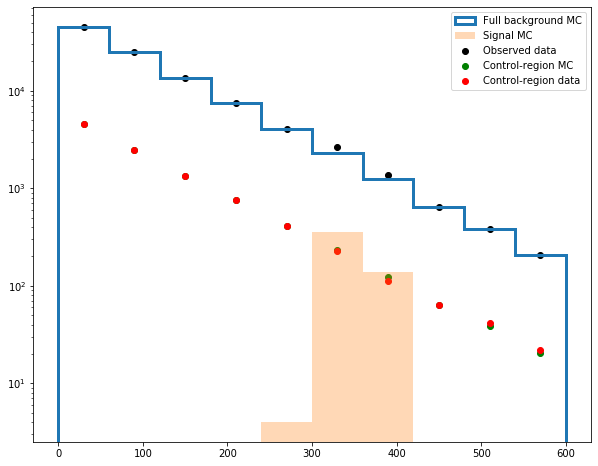

In [3]:
n_bins = 10
max_bin = 600
min_bin = 0

# Assuming this is Monte Carlo
plt.figure(figsize=(10,8))
background = np.random.exponential(100, round(1e5))
signal = np.random.normal(350,20, round(5e2))
bkg_count, _, _ = plt.hist(background, bins=n_bins, range=(min_bin, max_bin), histtype='step', linewidth=3, label='Full background MC')
sig_count, _, _ = plt.hist(signal, bins=n_bins, range=(min_bin, max_bin), histtype='stepfilled', alpha=0.3, label='Signal MC')
#sig_count = np.where(sig_count > 0, sig_count, 1e-10)
bin_width = (max_bin-min_bin)/n_bins
bin_center = np.arange(bin_width/2., max_bin, bin_width)
# Assuming this is data
background_with_noise = bkg_count #+ np.random.normal(0, np.sqrt(bkg_count)) 
signal_with_noise = sig_count #+ np.random.normal(0, np.sqrt(sig_count)) 
obs_data = background_with_noise + signal_with_noise
plt.scatter(bin_center, obs_data, color='black', label='Observed data')

# Assuming the control region is 10% data without signal presence
control_MC = 0.1 * bkg_count
control_region = 0.1 * background_with_noise + np.random.normal(0, np.sqrt(0.01*background_with_noise)) # data with some additional noise
plt.scatter(bin_center, control_MC, color='green', label='Control-region MC')
plt.scatter(bin_center, control_region, color='red', label='Control-region data')

plt.yscale('log')
plt.legend(loc='best')
plt.show()


In [4]:
# Defining necessary variables

# To avoid non-zero bins
eps = 1e-10
sig_count = sig_count + eps 

def get_likelihood(mu, b, s, tau, N, M):
    """
    s, b: array of bins for expected signal and background
    N: observed data
    M: observed background
    tau: scale factor for background
    s = 0 for null hypothesis, 1 for alternative hypothesis
    
    Return: L(N, M | mu,b,s,tau)
    """
    average_signal = mu * s + b
    A = stats.poisson.pmf(average_signal.astype(np.int), N) 
    B = stats.poisson.pmf((tau*b).astype(np.int), M)
    likelihood = A * B
    likelihood = np.where(likelihood < 1e-15, np.full_like(likelihood, 1e-15), likelihood)
    
    return likelihood

def get_mu_hat(N, M, tau, s):
    return (N-M/tau)/(s) 

def get_b_hat(M, tau):
    return M/tau

def get_b_doublehat(mu, b, s, tau, N, M):
    A = (N+M-(1+tau)*mu*s)/(2*(1+tau))
    B = np.sqrt(((N+M-(1+tau)*mu*s)**2 + 4*(1+tau)*M*mu*s)/(4*((1+tau)**2)))
    return A+B

def discovery_hypothesis_testing(bkg_count, sig_count, tau, M_obs, N_obs, N_asymov=round(1e5), show_plot=False):
    """
    bkg_count: Expected background from MC in control region, ie, 10% of data
    sig_count: Expected signal from MC
    M_obs: observed data from the control region
    N_obs: observed data from the signal region
    """
    # Get observed test statistics q_obs
    mu_hat = get_mu_hat(N=N_obs, M=M_obs, tau=tau, s=sig_count)
    b_hat = get_b_hat(M=M_obs, tau=tau)
    b_doublehat = get_b_doublehat(mu=0, b=bkg_count, s=sig_count, tau=tau, N=N_obs, M=M_obs)

    denominator = get_likelihood(mu=mu_hat, b=b_hat, s=sig_count, tau=tau, N=N_obs, M=M_obs)
    numerator = get_likelihood(mu=0, b=b_doublehat, s=sig_count, tau=tau, N=N_obs, M=M_obs)
    q_obs = -2*np.log(numerator/denominator)

    q_obs = np.where(mu_hat >= 0, q_obs, 0)
    q_obs = np.sum(q_obs, axis=-1)
    
    # Compute the Asimov dataset
    expected_data = bkg_count/tau 
    
    # Sample from expected MC
    obs_asymov = np.random.poisson(expected_data, (N_asymov, expected_data.shape[0])) 
    ctrl_asymov = np.random.poisson(bkg_count, (N_asymov, bkg_count.shape[0]))
    
    # Compute the necessary variables
    mu_hat = get_mu_hat(N=obs_asymov, M=ctrl_asymov, tau=tau, s=sig_count)
    b_hat = get_b_hat(M=ctrl_asymov, tau=tau)
    b_doublehat = get_b_doublehat(mu=0, b=bkg_count, s=sig_count, tau=tau, N=obs_asymov, M=ctrl_asymov)

    denominator = get_likelihood(mu=mu_hat, b=b_hat, s=sig_count, tau=tau, N=obs_asymov, M=ctrl_asymov)
    numerator = get_likelihood(mu=0, b=b_doublehat, s=sig_count, tau=tau, N=obs_asymov, M=ctrl_asymov)
    q_0 = -2*np.log(numerator/denominator)
    # Only take q_0 where mu_hat >= 0
    q_0 = np.where(mu_hat >= 0, q_0, 0)
    q_0 = np.sum(q_0, axis=-1)
    
    N_worse = np.sum(q_0 > q_obs)
    
    if show_plot:
        plt.figure(figsize=(10,8))
        binContent, _, _ = plt.hist(q_0, label='f($q_0$|0)', bins=40)
        plt.plot([q_obs, q_obs], [0,np.max(binContent)], label='Observed')
        plt.legend(loc='best')
        plt.xlabel('Test statistic')
        plt.yscale('log')
        plt.ylabel('Entries')
    
    pval = max(1., N_worse)/float(N_asymov)
    print("Observed test statistics: {}".format(q_obs))
    print("p-value: {}".format(pval))
    return pval


Observed test statistics: 6.999271927151996
p-value: 0.2704828


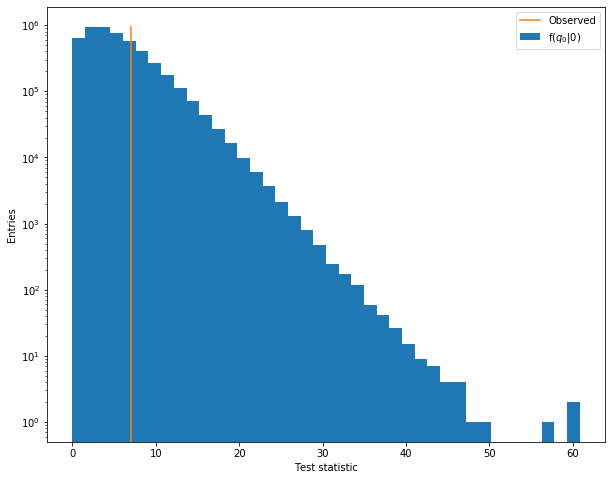

In [5]:
pval = discovery_hypothesis_testing(bkg_count=control_MC, sig_count=sig_count, 
                                    tau=0.1, M_obs=control_region, N_obs=obs_data, N_asymov=round(5e6), show_plot=True)

Obviously this counting experiment method only work when the expected signal in each bin is non-zero. In this toy example I put an artificial signal_count += 1e-10 for the expected signal. 

To do it correctly, we need to do the fit for the shape analysis. We'll use TMinuit for the fit because that's what physicists use.

# Shape Analysis

In the shape analysis, the PDF has the form

$p(n|\theta) = \prod_{i=1}^M \textrm{Poisson}(n_i, a_i(\theta)) $

where $a_i(\theta)$ is the mean count in bin $i$ and $\theta$ are the free parameters of the model. 

$a_i  = \int_{\textrm{bin_i}}[\mu \, f_s(x_i, \theta_s) + f_b(x_i, \theta_b)] \, dx_i\  \approx [\mu \, f_s(x_i, \theta_s) + f_b(x_i, \theta_b)] \Delta x $

The likelihood is just:

$\textrm{L}(\mu, \theta) = \prod_{i=1}^M \frac{\Delta x[\mu \, f_s(x_i, \theta_s) + f_b(x_i, \theta_b)]^{n_{i}}}{n_i!} e^{-\Delta x[\mu \, f_s(x_i, \theta_s) + f_b(x_i, \theta_b)]} $

Again we need to obtain test statistics from 

$\lambda(\mu) = \frac{L(\mu,\hat{\hat{\theta}})}{L(\hat{\mu}, \hat{\theta})}$

So for each Asimov dataset, we do 2 fits to get $\hat{\mu}, \hat{\theta}$ and $\hat{\hat{\theta}}$. 

Note that in our case, we consider signal is fully known, so we can directly take the signal MC template as $f_s$. When the bin width is small, we might want to do a Gaussian fit to the signal MC template first.


## Making the toy dataset

As oppose to bin counting experiment, shape analysis needs small bin width for better shape fitting.

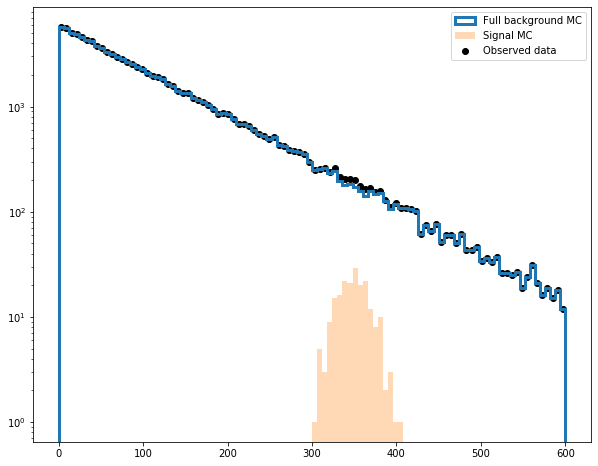

In [2]:
n_bins = 100
max_bin = 600
min_bin = 0
PEAK = 350

# Assuming this is Monte Carlo
plt.figure(figsize=(10,8))
background = np.random.exponential(100, round(1e5))
signal = np.random.normal(PEAK,20, round(2e2))
bkg_count, _, _ = plt.hist(background, bins=n_bins, range=(min_bin, max_bin), histtype='step', linewidth=3, label='Full background MC')
sig_count, _, _ = plt.hist(signal, bins=n_bins, range=(min_bin, max_bin), histtype='stepfilled', alpha=0.3, label='Signal MC')
#sig_count = np.where(sig_count > 0, sig_count, 1e-10)
bin_width = (max_bin-min_bin)/n_bins
bin_center = np.arange(bin_width/2., max_bin, bin_width)
# Assuming this is data
background_with_noise = bkg_count #+ np.random.normal(0, np.sqrt(bkg_count)) 
signal_with_noise = sig_count #+ np.random.normal(0, np.sqrt(sig_count)) 
obs_data = background_with_noise + signal_with_noise
plt.scatter(bin_center, obs_data, color='black', label='Observed data')

plt.yscale('log')
plt.legend(loc='best')
plt.show()


In [6]:
def get_likelihood(mu, s, b, N, dx):
    """
    Get the Poisson likelihood of observed data N given mu, s, b
    
    Parameters:
    s, b: array_like
        Array of bins for the expected signal and background. 
    dx: float
        Bin width
    N: array of bins for observed data
    s = 0 for null hypothesis, 1 for alternative hypothesis
    
    Return: 
    L(N | mu, s, b)
    """
    if s is None:
        average_signal = b*dx
    else:
        average_signal = (mu * s + b)*dx
    return stats.poisson.pmf(average_signal.astype(np.int), N*dx) 

def exp_func(x, coeff, scale):
    """Exponential function
    
    Parameters:
    coeff, scale, bias: float or array_like
        Function parameters
    x: array_like
        Bin centers
    
    Return:
    f(x) = coeff * exp(-scale*x) 
    """
    return coeff * np.exp(-scale * x) 

def gaussian_func(x, mu, sigma, coeff):
    """Gaussian function for the curve fit
    
    Parameters:
    mu, var, coeff: float or array_like
        Function parameters
    x: array_like
        Bin Center
    
    Return:
    f(x) = coeff/[var * sqrt(2pi)] * exp[-1/2 * ((x-mu)/var)^2]    
    """
    return coeff/(sigma * np.sqrt(2*np.pi)) * np.exp(-0.5 * np.power((x-mu)/sigma, 2))

def get_gaussian_params(x, template):
    """Get the Gaussian parameters from the signal template
    
    Parameters:
    x: array_like
        Bin centers
    template: array_like
        Signal template
        
    Returns:
    [mu, var, coeff]: array_like
        Parameters of the Gaussian
    """
    popt, pcov = curve_fit(gaussian_func, x, template, bounds=([300, 5, 0], [400, 200, np.inf]), method='trf') # please modify the bounds accordingly to your sig
    return popt 


def sb_func(x, mu, exp_coeff, exp_scale):
    """Basically mu*fs + fb
    
    Parameters: 
    x: array_like
        Bin center
    
    exp_coeff, exp_scale: array_like
        Parameters of the exponential background
    
    Return:
    f(x) = mu*fs + fb
        where fs is the SIGNAL_TEMPLATE obtained from fitting the signal before doing any minimization
    """
    global SIGNAL_TEMPLATE
    return mu * SIGNAL_TEMPLATE + exp_coeff * np.exp(-exp_scale * x) 

def get_theta_doublehat(bc, N):
    """Profile the likelihood for theta given N with mu = 0
    
    Parameters:
    bc: array_like
        Bin center
    N: array_like
        Observed data corresponding to the bin center
    
    Returns:
    [coeff, scale]: list of array_like
        Profile likelihood for the exponential function
    """
    
    popt, pcov = curve_fit(exp_func, bc, N, bounds=(0, np.inf), method='trf')

    return popt 


def get_muhat_thetahat(bc, N):
    """Profile the likelihood for mu and theta given N
    
    Parameters:
    bc: array_like
        Bin center
    N: array_like
        Observed data corresponding to the bin center
        
    Returns:
    [mu, exp_coeff, exp_scale]: list of array_like
        Profile likelihood for the combined function mu * fs + fb
    """
    popt, pcov = curve_fit(sb_func, bc, N, 
                           bounds=([-2, 0, 0],[2, np.inf, np.inf]), 
                           method='trf')
    return popt

def get_signal_template(bc, expected_signal):
    """Get the signal template from the MC bins
    Params:
    bc: array_like
        Bin center
    expected_signal: array_like
        Expected signal from MC
    
    Returns:
    gaus_func: array_like
        The smooth Gaussian function for signal with the same binning scheme
    """
    # Fit the signal template to get a smooth distributions (because the bin is high granularity)
    gauss_params = get_gaussian_params(bc, expected_signal)
    return gaussian_func(bc, gauss_params[0], gauss_params[1], gauss_params[2])

def get_test_statistics(bc, expected_bkg, expected_signal, obs_data, show_plot=False):
    """Get the test statistics given the observed data and expected MC
    
    Params:
    bc: array_like
        Bin center
    expected_bkg, expected_signal: array_like
        Expected bkg and signal from MC
    obs_data: array_like
        Observed data or Asimov data
    
    Returns:
    q0: float
        The test statistics for discovery
    """
    global SIGNAL_TEMPLATE
    bin_width = bc[1] - bc[0]
    
    # Get observed test statistics q_obs
    [exp_coeff, exp_scale] = get_theta_doublehat(bc, obs_data)
    fb_doublehat = exp_func(bc, exp_coeff, exp_scale)
    L_num = get_likelihood(mu=0, s=None, b=fb_doublehat, N=obs_data, dx=bin_width)
    
    [muhat, exp_coeff, exp_scale] = get_muhat_thetahat(bc, obs_data)
    if muhat < 0: 
        q_obs = 0
    else:
        fb = exp_func(bc, exp_coeff, exp_scale)
        L_deno = get_likelihood(mu=muhat, s=SIGNAL_TEMPLATE, b=fb, N=obs_data, dx=bin_width)
        q_obs = -2*np.log(L_num/L_deno)
        q_obs = np.sum(q_obs, axis=-1)
        
    if show_plot:
        plt.figure()
        plt.plot(bc, expected_signal, label='expected signal')
        plt.plot(bc, SIGNAL_TEMPLATE, label='template fit signal')
        plt.legend(loc='best')
        plt.show()    
        plt.figure()
        plt.plot(bc, expected_bkg, label='expected background')
        plt.plot(bc, fb_doublehat, label='template fit background')
        plt.legend(loc='best')
        plt.show()       
        
    return q_obs
    
def discovery_shape_analysis(bc, expected_bkg, expected_signal, obs_data, N_asimov=round(1e5), do_alternative=False, show_plot=False):
    """Generate the Asimov dataset and compute the pvalue of the observed data
    
    Parameters:
    bc: array_like
        Bin center
    expected_bkg, expected_signal: array_like
        Expected bkg and signal from MC
    obs_data: array_like
        Observed data
    N_asimov: int
        Number of Asimov datasets to generate to compute the p-value
    do_alternative: bool
        Whether to make Asimov dataset for signal hypothesis. Will take twice longer.
    show_plot: bool
        Whether to show the plot of the test statistics
    
    Return:
    pval: float
        p-value of the observed data
    """
    bin_width = bc[1] - bc[0]
    global SIGNAL_TEMPLATE
    SIGNAL_TEMPLATE = get_signal_template(bc, expected_signal)

    # Get observed test statistics q_obs
    q_obs = get_test_statistics(bc, expected_bkg, expected_signal, obs_data, show_plot=show_plot)

    # Compute the Asimov dataset
    
    q_0 = []
    q_1 = []
    skip = 0

    for i in tqdm(range(N_asimov)):
        obs_asimov = np.random.poisson(expected_bkg, (expected_bkg.shape[0],)) 
        
        try:
            q_0.append(get_test_statistics(bc, expected_bkg, expected_signal, obs_asimov, show_plot=False))
        except RuntimeError:
            skip += 1
            continue   
            
            
    if do_alternative:
        expected_sb = expected_bkg + expected_signal
        for i in tqdm(range(N_asimov)):
            obs_asimov_sig = np.random.poisson(expected_sb, (expected_sb.shape[0],)) 
            try:
                q_1.append(get_test_statistics(bc, expected_bkg, expected_signal, obs_asimov_sig, show_plot=False))
            except RuntimeError:
                skip += 1
                continue

    q_0 = np.asarray(q_0)
    N_worse = np.sum(q_0 > q_obs)
    
    if show_plot:
        plt.figure(figsize=(10,8))
        if do_alternative:
            min_q = min(min(q_0), min(q_1))
            max_q = max(max(q_0), max(q_1))
        else:
            min_q = min(q_0)
            max_q = max(q_0)
            
        binContent, _, _ = plt.hist(q_0, label='f($q_{0}$|0)', alpha=0.4, bins=80, range=(min_q, max_q))
        if do_alternative:
            binContentSig, _, _ = plt.hist(q_1, label='f($q_{0}$|1)', alpha=0.4, bins=80, range=(min_q, max_q))

        plt.plot([q_obs, q_obs], [0,np.max(binContent)], label='Observed')
        
        plt.legend(loc='best')
        plt.xlabel('Test statistic $q_{0}$')
        plt.yscale('log')
        plt.ylabel('Entries')
    
    pval = max(1., N_worse)/float(N_asimov)
    print(f"Skipped {skip} times during the minimization procedure.")
    print("\nObserved test statistics: {}".format(q_obs))
    print("p-value: {}".format(pval))
    return pval
    


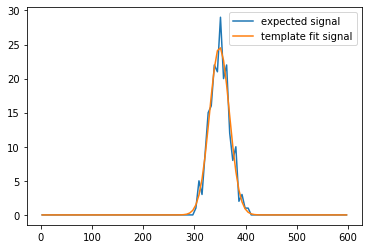

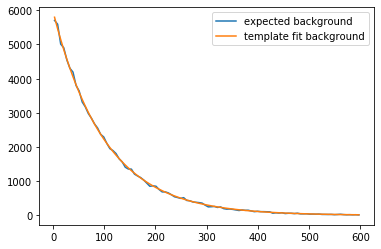

100%|██████████| 10000/10000 [04:19<00:00, 38.54it/s]


Skipped 0 times during the minimization procedure.

Observed test statistics: 20.150550083290682
p-value: 0.0002


0.0002

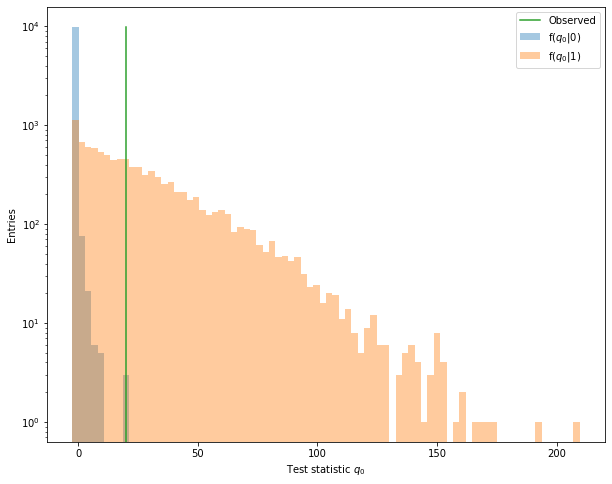

In [7]:
discovery_shape_analysis(bc=bin_center, expected_bkg=bkg_count, expected_signal=sig_count, 
                            obs_data=obs_data, N_asimov=round(1e4), do_alternative=True, show_plot=True)
    

Now making toy dataset with 0 signal for sanity check

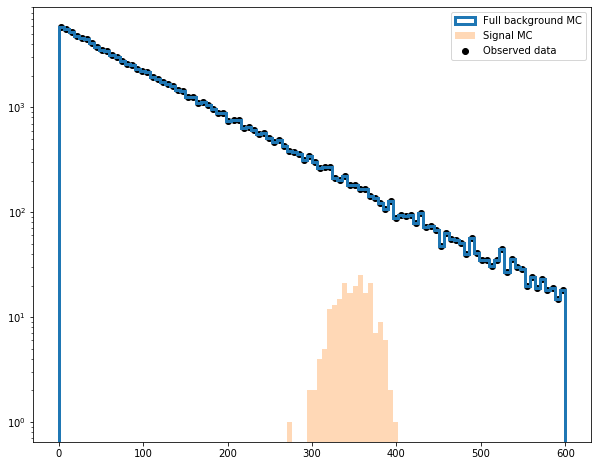

In [8]:
n_bins = 100
max_bin = 600
min_bin = 0
PEAK = 350

# Assuming this is Monte Carlo
plt.figure(figsize=(10,8))
background = np.random.exponential(100, round(1e5))
signal = np.random.normal(PEAK,20, round(2e2))
bkg_count, _, _ = plt.hist(background, bins=n_bins, range=(min_bin, max_bin), histtype='step', linewidth=3, label='Full background MC')
sig_count, _, _ = plt.hist(signal, bins=n_bins, range=(min_bin, max_bin), histtype='stepfilled', alpha=0.3, label='Signal MC')
#sig_count = np.where(sig_count > 0, sig_count, 1e-10)
bin_width = (max_bin-min_bin)/n_bins
bin_center = np.arange(bin_width/2., max_bin, bin_width)
# Assuming this is data
background_with_noise = bkg_count #+ np.random.normal(0, np.sqrt(bkg_count)) 
signal_with_noise = sig_count #+ np.random.normal(0, np.sqrt(sig_count)) 
obs_data = background_with_noise #+ signal_with_noise
plt.scatter(bin_center, obs_data, color='black', label='Observed data')

plt.yscale('log')
plt.legend(loc='best')
plt.show()


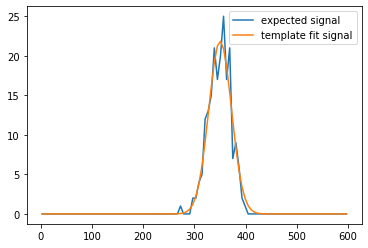

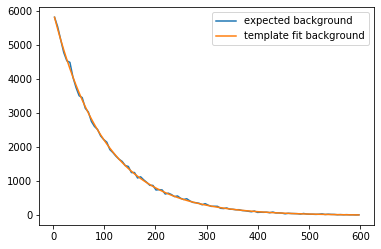

100%|██████████| 10000/10000 [04:21<00:00, 38.19it/s]


Skipped 0 times during the minimization procedure.

Observed test statistics: 0
p-value: 0.2064


0.2064

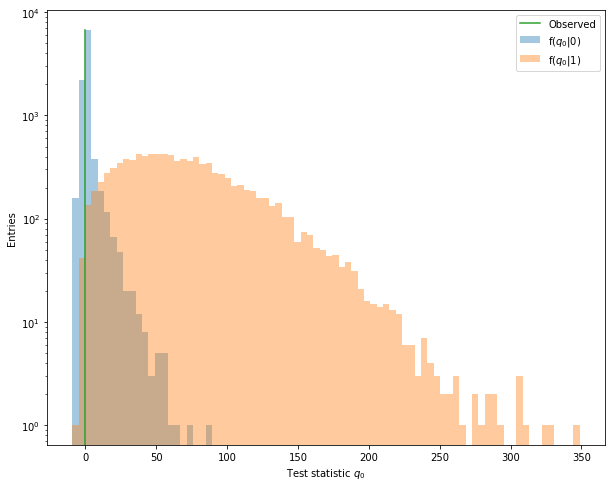

In [9]:
discovery_shape_analysis(bc=bin_center, expected_bkg=bkg_count, expected_signal=sig_count, 
                            obs_data=obs_data, N_asimov=round(1e4), do_alternative=True, show_plot=True)
    